In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import metrics
from tools.woe import WoEncoder
import seaborn as sns
from pylab import rcParams
import  matplotlib.pyplot as plt

from category_encoders import WOEEncoder

In [2]:
rcParams['figure.figsize'] = (10, 8)
sns.set(font_scale=2)
seed = random.randint(0, 100000)

In [3]:
def get_cols(dataframe: pd.DataFrame, columns: list):
    return dataframe[columns]

def drop_cols(dataframe: pd.DataFrame, columns: list):
    df = dataframe.copy(deep=True)
    df.drop(columns, axis=1, inplace=True)
    return df

def convert_to_int(dataframe: pd.DataFrame, column: str):
    df = dataframe.copy(deep=True)
    df[column] = df[column].apply(lambda row: np.NAN if not row.isnumeric() else int(row))
    return  df

def convert_to_str(dataframe: pd.DataFrame, column: str):
    df = dataframe.copy(deep=True)
    return df.astype({column: str})

def replace_cred_hist(dataframe, column='credit_history'):
    df = dataframe.copy(deep=True)
    df = df.replace({column: {1.0: 'Yes', 0.0: 'No'}})
    return df

def cat_missing_values(dataframe: pd.DataFrame, columns: list):
    df = dataframe.copy(deep=True)
    df_cat = df.loc[:, columns]
    df_num = df.drop(columns, axis=1)
    df_cat.fillna(value='MISSING', axis=0, inplace=True)
    return pd.concat([df_num, df_cat], axis=1)

def knn_add_columns(array: np.ndarray, num_columns: list):
    return pd.DataFrame(array, columns=num_columns)

def feature_engineer(dataframe: pd.DataFrame):
    df = dataframe.copy(deep=True)
    df['income/loan'] = df['income'] / (df['loan_in_thousands'] * 1000)
    df['total_income'] = df['income'] + df['spouse_income']
    df.drop(['spouse_income', 'income'], axis=1, inplace=True)
    return df

def continuous_woe(dataframe: pd.DataFrame, columns: list):
    encoder = WoEncoder(is_continuous=True)
    return encoder.fit_transform()

to_drop = ['id']
convert_to_int_col = 'spouse_income'
convert_to_str_col = 'monthly_payment'
categorical_cols = ['sex', 'married', 'dependents', 'education', 'working', 'monthly_payment', 'credit_history', 'property_type']
numerical_cols = ['income', 'spouse_income', 'loan_in_thousands']

In [4]:
fname = '../data/clients.csv'
df_init = pd.read_csv(fname)

# Preparing Target Variable
label_enc = LabelEncoder()
df_init.loc[:, 'loan_approval'] = label_enc.fit_transform(df_init['loan_approval'])
y = df_init['loan_approval']
X = df_init.drop('loan_approval', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed)


# CONFIG
CONTINUOUS_FEATURES = ['total_income', 'loan_in_thousands', 'income/loan']
CATEGORICAL_FEATURES = ['sex', 'married', 'dependents', 'education', 'working', 'monthly_payment', 'credit_history', 'property_type']

### Own Implementation

In [5]:
preprocess_cat = Pipeline(steps=[
    ('get_cat_feats', FunctionTransformer(func=get_cols, kw_args={'columns': categorical_cols})),
    ('convert_to_str', FunctionTransformer(func=convert_to_str, kw_args={'column': convert_to_str_col})),
    ('replace_cred_hist', FunctionTransformer(func=replace_cred_hist)),
    ('cat_missing_values', FunctionTransformer(func=cat_missing_values, kw_args={'columns': categorical_cols})),
    ('woe_encoder', WoEncoder(is_continuous=False)),
])
preprocess_num = Pipeline(steps=[
    ('get_num_feats', FunctionTransformer(func=get_cols, kw_args={'columns': numerical_cols})),
    ('convert_to_int', FunctionTransformer(func=convert_to_int, kw_args={'column': convert_to_int_col})),
    ('knn', KNNImputer(n_neighbors=3)),
    ('knn_add_columns', FunctionTransformer(func=knn_add_columns, kw_args={'num_columns': numerical_cols})),
    ('feature_engineer', FunctionTransformer(func=feature_engineer)),
    ('woe_encoder', WoEncoder(is_continuous=True)),
])
unite_pipes = FeatureUnion(transformer_list=[
    ('cats', preprocess_cat),
    ('nums', preprocess_num)
])
pipeline = Pipeline(steps=[
    ('drop_cols', FunctionTransformer(func=drop_cols, kw_args={'columns': to_drop})),
    ('united', unite_pipes),
    ('log', LogisticRegression())
])

### Feature Engine Implementation

In [6]:
preprocess_cat_fe = Pipeline(steps=[
    ('get_cat_feats', FunctionTransformer(func=get_cols, kw_args={'columns': categorical_cols})),
    ('convert_to_str', FunctionTransformer(func=convert_to_str, kw_args={'column': convert_to_str_col})),
    ('replace_cred_hist', FunctionTransformer(func=replace_cred_hist)),
    ('cat_missing_values', FunctionTransformer(func=cat_missing_values, kw_args={'columns': categorical_cols})),
])
preprocess_num_fe = Pipeline(steps=[
    ('get_num_feats', FunctionTransformer(func=get_cols, kw_args={'columns': numerical_cols})),
    ('convert_to_int', FunctionTransformer(func=convert_to_int, kw_args={'column': convert_to_int_col})),
    ('knn', KNNImputer(n_neighbors=3)),
    ('knn_add_columns', FunctionTransformer(func=knn_add_columns, kw_args={'num_columns': numerical_cols})),
    ('feature_engineer', FunctionTransformer(func=feature_engineer)),
])
unite_pipes_fe = FeatureUnion(transformer_list=[
    ('cats', preprocess_cat_fe),
    ('nums', preprocess_num_fe)
])
pipeline_fe = Pipeline(steps=[
    ('drop_cols', FunctionTransformer(func=drop_cols, kw_args={'columns': to_drop})),
    ('united', unite_pipes_fe),
    ('woe', WOEEncoder(cols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])),
    ('log', LogisticRegression())
])

In [7]:
pipeline.fit(X_train.copy(deep=True), y_train)

Pipeline(steps=[('drop_cols',
                 FunctionTransformer(func=<function drop_cols at 0x12731c700>,
                                     kw_args={'columns': ['id']})),
                ('united',
                 FeatureUnion(transformer_list=[('cats',
                                                 Pipeline(steps=[('get_cat_feats',
                                                                  FunctionTransformer(func=<function get_cols at 0x12731c3a0>,
                                                                                      kw_args={'columns': ['sex',
                                                                                                           'married',
                                                                                                           'dependents',
                                                                                                           'education',
                                                        

In [8]:
pipeline_fe.fit(X_train, y_train)

Pipeline(steps=[('drop_cols',
                 FunctionTransformer(func=<function drop_cols at 0x12731c700>,
                                     kw_args={'columns': ['id']})),
                ('united',
                 FeatureUnion(transformer_list=[('cats',
                                                 Pipeline(steps=[('get_cat_feats',
                                                                  FunctionTransformer(func=<function get_cols at 0x12731c3a0>,
                                                                                      kw_args={'columns': ['sex',
                                                                                                           'married',
                                                                                                           'dependents',
                                                                                                           'education',
                                                        

In [9]:
print(f"Own Implementation of Weight of Evidence Encoder:\nF1 Score: {metrics.f1_score(y_test, pipeline.predict(X_test)): .3f}")
print(f'\nFeature Engine Implementation of Implementation of Weight of Evidence Encoder:\nF1 Score; {metrics.f1_score(y_test, pipeline_fe.predict(X_test)): .3f}')

Own Implementation of Weight of Evidence Encoder:
F1 Score:  0.864

Feature Engine Implementation of Implementation of Weight of Evidence Encoder:
F1 Score;  0.827


In [10]:
conf = pd.DataFrame(metrics.confusion_matrix(y_true=y_test, y_pred=pipeline.predict(X_test)))
conf_fe = pd.DataFrame(metrics.confusion_matrix(y_true=y_test, y_pred=pipeline_fe.predict(X_test)))

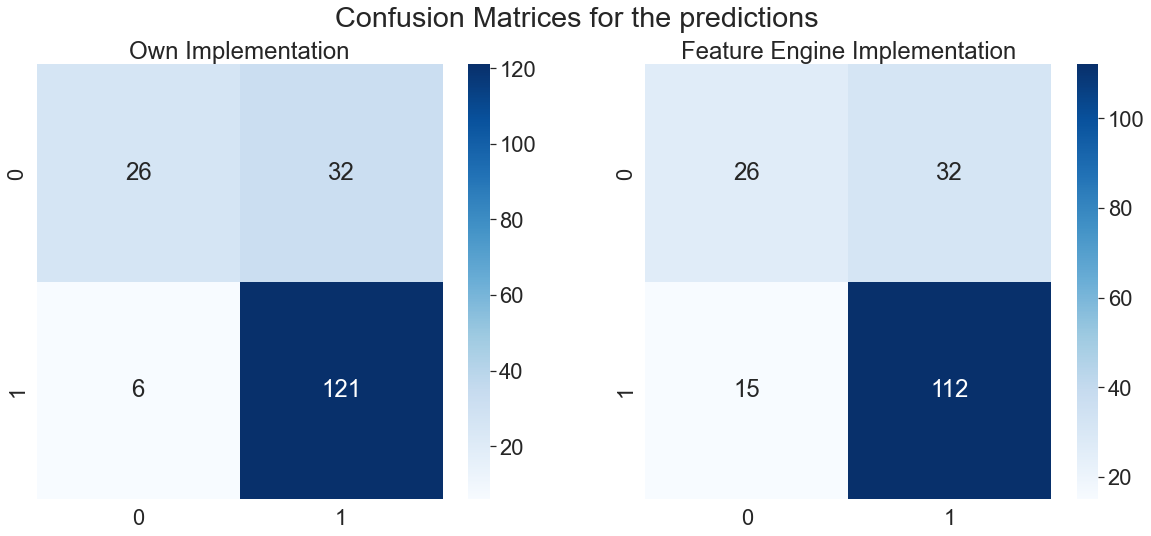

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Confusion Matrices for the predictions')
sns.heatmap(data=conf, annot=True, cmap='Blues',  fmt='g', ax=ax[0])
ax[0].set_title('Own Implementation')
sns.heatmap(data=conf_fe, annot=True, cmap='Blues',  fmt='g', ax=ax[1])
ax[1].set_title('Feature Engine Implementation');